In [1]:
from google.colab import drive
drive.mount('/content/drive/')

DRIVE_ROOT = "/content/drive/My Drive/papers/deepfill"

!cp "/content/drive/My Drive/papers/deepfill/generative-inpainting-pytorch/model/networks.py" ./generative_networks.py
!cp -r "/content/drive/My Drive/papers/deepfill/generative-inpainting-pytorch/utils" .

!cp "/content/drive/My Drive/papers/deepfill/RFR-Inpainting/model.py" ./rfr_model.py
!cp -r "/content/drive/My Drive/papers/deepfill/RFR-Inpainting/modules" .
!cp "/content/drive/My Drive/papers/deepfill/RFR-Inpainting/utils/io.py" ./utils/io.py

!cp "/content/drive/My Drive/papers/deepfill/RN/models.py" ./rn_model.py
!cp "/content/drive/My Drive/papers/deepfill/RN/networks.py" ./networks.py
!cp "/content/drive/My Drive/papers/deepfill/RN/rn.py" ./rn.py

!cp -r "/content/drive/My Drive/papers/deepfill/StructureFlow/src" .
#!cp -r "/content/drive/My Drive/papers/deepfill/StructureFlow/resample2d_package" .

!cp -r "/content/drive/My Drive/papers/deepfill/crfill/networks" ./cr_networks

!cp "/content/drive/My Drive/papers/deepfill/inpainting_gmcnn/pytorch/model/net.py" ./gmcnn_net.py
!cp -r "/content/drive/My Drive/papers/deepfill/inpainting_gmcnn/pytorch/model/" .
!cp -r "/content/drive/My Drive/papers/deepfill/inpainting_gmcnn/pytorch/util/" .

!cp -r "/content/drive/My Drive/papers/deepfill/edge-connect/src/" .

#!cd resample2d_package && make.sh

!pip install pytorch-msssim

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
import torch
import yaml
import numpy as np
from PIL import Image

import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.utils as vutils
from pytorch_msssim import ssim

import matplotlib
import matplotlib.pyplot as plt

CUDA = True
device = torch.device("cuda" if CUDA else "cpu")

In [ ]:
#!apt-get install tree
#!tree -L 2 "/content/drive/My Drive/papers/deepfill/pretrained"

In [ ]:
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/daa233/generative-inpainting-pytorch
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/KumapowerLIU/CSA-inpainting
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/SayedNadim/Global-and-Local-Attention-Based-Free-Form-Image-Inpainting
#!git -C "/content/drive/MyDrive/papers/deepfill/" clone https://github.com/RenYurui/StructureFlow
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/jingyuanli001/RFR-Inpainting
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/geekyutao/RN
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/zengxianyu/crfill
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/JiahuiYu/generative_inpainting
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/shepnerd/inpainting_gmcnn
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/bobqywei/inpainting-partial-conv
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/knazeri/edge-connect

In [3]:
GENERATIVE = 0
RFR = 1
RN = 2
CRFILL = 3
GMCNN = 4
EDGE_CONNECT = 5
PARTIAL_CONV = 6
STRUCTURE_FLOW = 7

img_shape = [256, 256, 3]

def pil_load(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

# GMCNN
class Options:
    def __init__(self):
        self.phase = 'test'
        self.gpu_ids = [0]
        self.model_folder = ""
        self.g_cnum = 32

# EDGE_CONNECT
from skimage.feature import canny
from skimage.color import rgb2gray, gray2rgb
def generate_edge(img, mask):
    mask = (1 - mask).astype(np.bool)
    return canny(img, sigma=2, mask=mask).astype(np.float)

class EC_Config:
    def __init__(self):
        entries = {
            'MODE': 2,                      # 1: train, 2: test, 3: eval
            'MODEL': 4,                     # 1: edge model, 2: inpaint model, 3: edge-inpaint model, 4: joint model
            'MASK': 3,                      # 1: random block, 2: half, 3: external, 4: (external, random block), 5: (external, random block, half)
            'EDGE': 1,                      # 1: canny, 2: external
            'NMS': 1,                       # 0: no non-max-suppression, 1: applies non-max-suppression on the external edges by multiplying by Canny
            'SEED': 10,                     # random seed
            'GPU': [0],                     # list of gpu ids
            'DEBUG': 0,                     # turns on debugging mode
            'VERBOSE': 0,                   # turns on verbose mode in the output console
            'PATH': "",

            'LR': 0.0001,                   # learning rate
            'D2G_LR': 0.1,                  # discriminator/generator learning rate ratio
            'BETA1': 0.0,                   # adam optimizer beta1
            'BETA2': 0.9,                   # adam optimizer beta2
            'BATCH_SIZE': 8,                # input batch size for training
            'INPUT_SIZE': 256,              # input image size for training 0 for original size
            'SIGMA': 2,                     # standard deviation of the Gaussian filter used in Canny edge detector (0: random, -1: no edge)
            'MAX_ITERS': 2e6,               # maximum number of iterations to train the model

            'EDGE_THRESHOLD': 0.5,          # edge detection threshold
            'L1_LOSS_WEIGHT': 1,            # l1 loss weight
            'FM_LOSS_WEIGHT': 10,           # feature-matching loss weight
            'STYLE_LOSS_WEIGHT': 1,         # style loss weight
            'CONTENT_LOSS_WEIGHT': 1,       # perceptual loss weight
            'INPAINT_ADV_LOSS_WEIGHT': 0.01,# adversarial loss weight

            'GAN_LOSS': 'nsgan',            # nsgan | lsgan | hinge
            'GAN_POOL_SIZE': 0,             # fake images pool size

            'SAVE_INTERVAL': 1000,          # how many iterations to wait before saving model (0: never)
            'SAMPLE_INTERVAL': 1000,        # how many iterations to wait before sampling (0: never)
            'SAMPLE_SIZE': 12,              # number of images to sample
            'EVAL_INTERVAL': 0,             # how many iterations to wait before model evaluation (0: never)
            'LOG_INTERVAL': 10,             # how many iterations to wait before logging training status (0: never)
        }

        self.__dict__.update(entries)

# vgg19
from collections import namedtuple

CONTENT_WEIGHT = 1
STYLE_WEIGHTS = np.array([1e-1, 1, 1e1, 5, 1e1]) * 1e4
REGULARIZATION = 1e-6

vgg_model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True).to(device)
vgg_model.eval()
LossOutput = namedtuple("LossOutput", ["relu1", "relu2", "relu3", "relu4", "relu5"])
# https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1",
            '8': "relu2",
            '17': "relu3",
            '26': "relu4",
            '35': "relu5",
        }
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram
def vgg_norm():
    return transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]) 
def vgg_recover(img):
    return (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

loss_network = LossNetwork(vgg_model).to(device)
loss_network.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [4]:
# generative-inpainting
from generative_networks import Generator as GENERATIVE_Generator
from utils.tools import normalize
# rfr-inpainting
from rfr_model import RFRNetModel as RFR_Model
from modules.RFRNet import RFRNet
# RN
from rn_model import InpaintingModel as RN_Model
# crfill
from cr_networks.convnet import InpaintGenerator as CR_Model
# gmcnn
from gmcnn_net import InpaintingModel_GMCNN as GMCNN_Model
# edge connect
from src.models import EdgeModel as EC_EdgeModel
from src.models import InpaintingModel as EC_InpaintModel
# StructureFlow
#from src.models import StructureFlowModel


def load_data(image_path, mask_path):
    x    = pil_load(image_path)
    mask = pil_load(mask_path)

    x = transforms.Resize(img_shape[:-1])(x)
    x = transforms.CenterCrop(img_shape[:-1])(x)

    mask = transforms.Resize(img_shape[:-1])(mask)
    mask = transforms.CenterCrop(img_shape[:-1])(mask)

    return x, mask

def normalise(x):
    return x * 2. - 1.

def run(model, x, mask):
  
    if model == GENERATIVE:
        x = transforms.ToTensor()(x).to(device)
        mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)
        x = normalise(x)
        x = x * (1. - mask)
        x = x.unsqueeze(dim=0)
        mask = mask.unsqueeze(dim=0)

        netG = GENERATIVE_Generator({'input_dim': 3, 'ngf': 32}, CUDA, [0])
        netG.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/generative-inpainting-pytorch/imagenet/gen_00430000.pt", map_location=device))

        if CUDA:
            netG = nn.parallel.DataParallel(netG, device_ids=[0])
            x = x.cuda()
            mask = mask.cuda()

        # Inference
        x1, x2, offset_flow = netG(x, mask)
        inpainted_result = x2 * mask + x * (1. - mask)
        # 0 to 1 range
        return (inpainted_result + 1) / 2.

    elif model == RFR:
        rfr_model = RFR_Model()

        rfr_model.G = RFRNet()
        _temp = torch.load(f"{DRIVE_ROOT}/pretrained/RFR-Inpainting/celeba/checkpoint_celeba.pth", map_location=device)
        #_temp = torch.load(f"{DRIVE_ROOT}/pretrained/RFR-Inpainting/places/checkpoint_paris.pth", map_location=device)
        rfr_model.G.load_state_dict(_temp['generator'], strict=False)

        if CUDA:
            rfr_model.cuda()

        rfr_model.G.eval()

        x = transforms.ToTensor()(x).to(device)
        mask = transforms.ToTensor()(mask).to(device)

        x = x * (1. - mask)
        x = x.unsqueeze(dim=0)
        
        mask = mask.unsqueeze(dim=0)

        fake_B, _ = rfr_model.G(x, 1 - mask)

        comp_B = fake_B * mask  + x * (1. - mask)
        # 0 to 1 range
        return torch.clip(comp_B, 0., 1.)
        #return (comp_B - torch.min(comp_B)) / (torch.max(comp_B) - torch.min(comp_B))

    elif model == RN:
        model = RN_Model(g_lr=0.0001, d_lr=0.001, l1_weight=1.0, gan_weight=0.1, iter=0, threshold=0.8)
        pretained_model = torch.load(f"{DRIVE_ROOT}/pretrained/RN/places2/x_admin.cluster.localRN-0.8RN-Net_bs_14_epoch_3.pth", map_location=device)

        if CUDA:
            model = model.cuda()
            model.generator = torch.nn.DataParallel(model.generator, device_ids=[0])
            model.discriminator = torch.nn.DataParallel(model.discriminator, device_ids=[0])
            model.load_state_dict(pretained_model, strict=False)
        else:
            new_state_dict = model.state_dict()
            for k, v in pretained_model.items():
                k = k.replace('module.', '')
                new_state_dict[k] = v
            model.load_state_dict(new_state_dict)

        model.eval()
        model.generator.eval()

        x = transforms.ToTensor()(x).to(device)
        mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)

        x = x * (1. - mask)
        x = x.unsqueeze(dim=0)
        
        mask = mask.unsqueeze(dim=0)

        fake_B = model.generator(x, mask)

        comp_B = fake_B * mask  + x * (1. - mask)
        # 0 to 1 range
        return comp_B

    elif model == CRFILL:
        model = CR_Model()
        model.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/crfill/places2/model_256.pth", map_location=device))
        model.to(device)

        x = transforms.ToTensor()(x).to(device)
        mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)
        x = normalise(x)
        x = x * (1. - mask)
        x = x.unsqueeze(dim=0)
        mask = mask.unsqueeze(dim=0)

        _, result = model(x, mask)

        full_result = result * mask + x * (1. - mask)
        # 0 to 1 range
        return (full_result + 1) / 2.
    
    elif model == GMCNN:

        model = GMCNN_Model(in_channels=4, opt=Options())
        model.load_networks(f"{DRIVE_ROOT}/pretrained/inpainting_gmcnn/celeba/10_net_GM.pth")
        model.to(device)

        x = transforms.ToTensor()(x).to(device)
        mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)
        x = normalise(x)
        x = x * (1. - mask)
        x = x.unsqueeze(dim=0)
        mask = mask.unsqueeze(dim=0)

        # Inference
        x2 = model.netGM(torch.cat((x, mask), 1))
        inpainted_result = x2 * mask + x * (1. - mask)
        # 0 to 1 range
        return (inpainted_result + 1) / 2.
    
    elif model == EDGE_CONNECT:

        edge_model = EC_EdgeModel(EC_Config()).to(device)
        inpaint_model = EC_InpaintModel(EC_Config()).to(device)

        edge_model.generator.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/edge-connect/celeba/EdgeModel_gen.pth", map_location=device)['generator'])
        inpaint_model.generator.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/edge-connect/celeba/InpaintingModel_gen.pth", map_location=device)['generator'])

        grey_x = transforms.ToTensor()(rgb2gray(np.array(x))).to(device)
        x = transforms.ToTensor()(x).to(device)

        mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)
        edge = generate_edge(grey_x[0].cpu().detach().numpy(), mask.squeeze(0).cpu().detach().numpy())
        edge = transforms.ToTensor()(edge).float().to(device).unsqueeze(0)

        x = x * (1. - mask)
        x = x.unsqueeze(dim=0)
        grey_x = grey_x * (1. - mask)
        grey_x = grey_x.float().unsqueeze(dim=0)
        mask = mask.unsqueeze(dim=0)

        edges = edge_model(grey_x, edge, mask).detach()
        outputs = inpaint_model(x, edges, mask)
        outputs_merged = (outputs * mask) + (x * (1 - mask))

        # 0 to 1 range
        return outputs_merged

    elif model == PARTIAL_CONV:
        return None

    elif model == STRUCTURE_FLOW:
        return None
        model = StructureFlowModel(load_config('test')).to(device)

        model.s_gen.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/StructureFlow/places/latest_net_s_gen.pth", map_location=device))
        model.f_gen.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/StructureFlow/places/latest_net_f_gen.pth", map_location=device))

        x = transforms.ToTensor()(x).to(device)
        mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)

        x = x * (1. - mask)
        x = x.unsqueeze(dim=0)
        
        mask = mask.unsqueeze(dim=0)

        # smooth comes from http://www.cse.cuhk.edu.hk/~leojia/projects/texturesep/
        smooth_stage_1 = model.structure_forward(x, smooths, mask)
        outputs, _ = model.flow_forward(x, smooth_stage_1, mask)

        outputs_merged = outputs * mask + x * (1 - mask)

        # 0 to 1 range
        return outputs_merged


def plot_all(name_map, _x, _mask, target, image=None, mask=None):
    fig=plt.figure(figsize=(15, 15))

    for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)

        ax.set_title(name_map[i])
        if i < 6:
            inpainted_result = run(i, _x, _mask)
            img = inpainted_result[0].permute(1, 2, 0).detach().cpu().numpy()
        elif i == 6:
            img = pil_load(image) if image is not None else _x
        elif i == 7:
            img = pil_load(mask) if mask is not None else _mask
        elif i == 8:
            img = target
        elif i == 9:
            img = _x
        plt.imshow(img)
    plt.show()


In [5]:
def run_preloaded_0to1(model_name, model, x, mask):

    if model_name == RFR:
        
        x = x * (1. - mask)

        mask = mask.squeeze()
        mask = torch.stack([mask] * 3)
        mask = mask.unsqueeze(dim=0)

        fake_B, _ = model(x, 1 - mask)

        comp_B = fake_B * mask  + x * (1. - mask)
        # 0 to 1 range
        return torch.clip(comp_B, 0., 1.)

    elif model_name == RN:
        
        x = x * (1. - mask)

        mask = mask.unsqueeze(dim=0)

        fake_B = model(x, mask)

        comp_B = fake_B * mask  + x * (1. - mask)
        # 0 to 1 range
        return comp_B

    elif model_name == EDGE_CONNECT:

        grey_x = transforms.ToTensor()(rgb2gray(x[0].permute(1, 2, 0).cpu().detach().numpy())).to(device)

        edge = generate_edge(grey_x[0].cpu().detach().numpy(), mask.squeeze(0).cpu().detach().numpy())
        edge = transforms.ToTensor()(edge).float().to(device).unsqueeze(0)

        x = x * (1. - mask)
        grey_x = grey_x * (1. - mask)
        grey_x = grey_x.float().unsqueeze(dim=0)

        mask = mask.unsqueeze(dim=0)

        edges = model[0](grey_x, edge, mask).detach()
        outputs = model[1](x, edges, mask)
        outputs_merged = (outputs * mask) + (x * (1 - mask))

        # 0 to 1 range
        return outputs_merged

# pass normalised x in
def run_preloaded_m1to1(model_name, model, x, mask):
  
    if model_name == GENERATIVE:
        
        x = x * (1. - mask)

        mask = mask.unsqueeze(dim=0)

        x1, x2, offset_flow = model(x, mask)
        inpainted_result = x2 * mask + x * (1. - mask)
        # -1 to 1 range
        return inpainted_result

    elif model_name == CRFILL:

        x = x * (1. - mask)

        mask = mask.unsqueeze(dim=0)

        _, result = model(x, mask)

        full_result = result * mask + x * (1. - mask)
        # -1 to 1 range
        return full_result
    
    elif model_name == GMCNN:
        
        x = x * (1. - mask)

        mask = mask.unsqueeze(dim=0)

        x2 = model(torch.cat((x, mask), 1))
        inpainted_result = x2 * mask + x * (1. - mask)
        # -1 to 1 range
        return inpainted_result

In [6]:
import torch.nn.functional as F
from torch.autograd import Variable

# pre-load all models
models = []
netG = GENERATIVE_Generator({'input_dim': 3, 'ngf': 32}, CUDA, [0])
netG.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/generative-inpainting-pytorch/imagenet/gen_00430000.pt", map_location=device))
if CUDA:
    netG = nn.parallel.DataParallel(netG, device_ids=[0])
netG.to(device)
netG.eval()
models.append(netG)
#
rfr_model = RFR_Model()
rfr_model.G = RFRNet()
_temp = torch.load(f"{DRIVE_ROOT}/pretrained/RFR-Inpainting/celeba/checkpoint_celeba.pth", map_location=device)
#_temp = torch.load(f"{DRIVE_ROOT}/pretrained/RFR-Inpainting/places/checkpoint_paris.pth", map_location=device)
rfr_model.G.load_state_dict(_temp['generator'], strict=False)

if CUDA:
    rfr_model.cuda()
rfr_model.G.eval()
models.append(rfr_model.G)
#
rnmodel = RN_Model(g_lr=0.0001, d_lr=0.001, l1_weight=1.0, gan_weight=0.1, iter=0, threshold=0.8)
rnpretained_model = torch.load(f"{DRIVE_ROOT}/pretrained/RN/places2/x_admin.cluster.localRN-0.8RN-Net_bs_14_epoch_3.pth", map_location=device)

if CUDA:
    rnmodel = rnmodel.cuda()
    rnmodel.generator = torch.nn.DataParallel(rnmodel.generator, device_ids=[0])
    rnmodel.discriminator = torch.nn.DataParallel(rnmodel.discriminator, device_ids=[0])
    rnmodel.load_state_dict(rnpretained_model, strict=False)
else:
    new_state_dict = rnmodel.state_dict()
    for k, v in pretained_model.items():
        k = k.replace('module.', '')
        new_state_dict[k] = v
    rnmodel.load_state_dict(new_state_dict)

rnmodel.eval()
rnmodel.generator.eval()
models.append(rnmodel.generator)
#
crmodel = CR_Model()
crmodel.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/crfill/places2/model_256.pth", map_location=device))
crmodel.to(device)
crmodel.eval()
models.append(crmodel)
#
gmcnnmodel = GMCNN_Model(in_channels=4, opt=Options())
gmcnnmodel.load_networks(f"{DRIVE_ROOT}/pretrained/inpainting_gmcnn/celeba/10_net_GM.pth")
gmcnnmodel.to(device)
gmcnnmodel.eval()
gmcnnmodel.netGM.eval()
models.append(gmcnnmodel.netGM)
#
edge_model = EC_EdgeModel(EC_Config()).to(device)
inpaint_model = EC_InpaintModel(EC_Config()).to(device)

edge_model.generator.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/edge-connect/celeba/EdgeModel_gen.pth", map_location=device)['generator'])
inpaint_model.generator.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/edge-connect/celeba/InpaintingModel_gen.pth", map_location=device)['generator'])

edge_model.eval()
inpaint_model.eval()

models.append((edge_model, inpaint_model))
#

Model moved to cuda
initialize network with normal
loading the model from /content/drive/My Drive/papers/deepfill/pretrained/inpainting_gmcnn/celeba/10_net_GM.pth


In [7]:
image_path = f"{DRIVE_ROOT}/putin_trump.png" # f"{DRIVE_ROOT}/eye.png" 
image_target_path = f"{DRIVE_ROOT}/putin_trump_target.png" #f"{DRIVE_ROOT}/eye.png" 
mask_path  = f"{DRIVE_ROOT}/putin_trump_mask.png" #f"{DRIVE_ROOT}/eye_mask.png" 

#x = pil_load(image_path)
#targ = pil_load(image_target_path)

#mask = pil_load(mask_path)
#mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)

def requires_norm(j):
    return j in [0, 3, 4]
unnorm = lambda x: (x + 1) / 2

COLOUR_WEIGHT = 4.

epsilons = [0.1] #[0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3]

def get_l1_l2_losses_against_eps(x_img, target_img, mask, TARGET_MODELS):

    losses = []
    for _ in range(6):
        losses.append({
            'l2_target': [],
            'l1_target': [],
            'psnr_target': [],
            'ssim_target': [],

            'l2_orig': [],
            'l1_orig': [],
            'psnr_orig': [],
            'ssim_orig': [],
            
            'l2_wouldhave': [],
            'l1_wouldhave': [],
            'psnr_wouldhave': [],
            'ssim_wouldhave': [],

        })

    targ = transforms.ToTensor()(target_img).to(device)
    targ = transforms.Resize(img_shape[:-1])(targ)
    
    x = transforms.ToTensor()(x_img).to(device)
    x = transforms.Resize(img_shape[:-1])(x)
    x = transforms.CenterCrop(img_shape[:-1])(x)

    norm_x = normalise(x)

    target = (targ * mask + x * (1. - mask)).unsqueeze(0)
    norm_target = normalise(target.clone())

    wouldhave_results = []
    for j in range(6):
        model = models[j]
        run_preloaded = run_preloaded_m1to1 if requires_norm(j) else run_preloaded_0to1
        wouldhave_results.append(run_preloaded(j, model, (norm_x if requires_norm(j) else x).unsqueeze(dim=0), mask))

    # calculate gram matrices of style image (target in this case)
    with torch.no_grad():
        style_loss_features = loss_network(target)
        gram_style = [gram_matrix(y) for y in style_loss_features]

    for epsilon in epsilons:
        #x = pil_load(image_path)
        x = transforms.ToTensor()(x_img).to(device)
        x = transforms.Resize(img_shape[:-1])(x)
        x = transforms.CenterCrop(img_shape[:-1])(x)
        x = x.unsqueeze(dim=0)
        
        norm_x = normalise(x)

        _x = x.clone()
        _norm_x = norm_x.clone()

        iters = 500.0 # 500 at 0.1 for combined
        step = epsilon / 50
        i = 0

        upper = torch.clamp(x + epsilon, min=0, max=1)
        lower = torch.clamp(x - epsilon, min=0, max=1)

        norm_upper = torch.clamp(norm_x + epsilon, min=-1, max=1)
        norm_lower = torch.clamp(norm_x - epsilon, min=-1, max=1)

        #plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
        #plt.show()

        # change order to pick which model's datagrad to use
        #TARGET_MODELS = [2] #[0, 1, 2, 3, 4]
        
        while i < iters:
            i += 1

            cumulative_datagrad = None
            for j in TARGET_MODELS:
                model = models[j]

                var_x = Variable(norm_x if requires_norm(j) else x, requires_grad=True)

                if var_x.grad is not None:
                    var_x.grad.data.zero_()

                var_x.retain_grad()
                run_preloaded = run_preloaded_m1to1 if requires_norm(j) else run_preloaded_0to1
                full_result = run_preloaded(j, model, var_x, mask)

                colour_loss = COLOUR_WEIGHT * F.mse_loss(full_result, norm_target if requires_norm(j) else target)

                # vgg visual loss
                # loss_network only operates on [0, 1] range
                features_full = loss_network(unnorm(full_result) if requires_norm(j) else full_result)
                features_input = loss_network(target)

                content_loss = CONTENT_WEIGHT * F.mse_loss(features_full[2], features_input[2])

                reg_loss = REGULARIZATION * (
                        torch.sum(torch.abs(full_result[:, :, :, :-1] - full_result[:, :, :, 1:])) + 
                        torch.sum(torch.abs(full_result[:, :, :-1, :] - full_result[:, :, 1:, :])))
                
                style_loss = 0.
                for l, weight in enumerate(STYLE_WEIGHTS):
                    gram_s = gram_style[l]
                    gram_y = gram_matrix(features_full[l])
                    style_loss += float(weight) * F.mse_loss(gram_y, gram_s.expand_as(gram_y))
                
                total_loss = content_loss + style_loss + reg_loss + colour_loss

                # if i % 30 == 0:
                #     print(i, total_loss)
                if type(model) is not tuple:
                    model.zero_grad()
                else:
                    for m in model:
                        m.zero_grad()
                total_loss.backward()

                # Collect datagrad
                data_grad = var_x.grad.data.sign() * step

                # Sum datagrads from models in loop
                if cumulative_datagrad is None:
                    cumulative_datagrad = data_grad
                else:
                    cumulative_datagrad += data_grad

            x = (x - (cumulative_datagrad[0] * (1 - mask)))
            x = torch.max(torch.min(x, upper), lower)
            norm_x = (norm_x - (cumulative_datagrad[0] * (1 - mask)))
            norm_x = torch.max(torch.min(norm_x, norm_upper), norm_lower)

            attack_img = x.clone().squeeze().permute(1, 2, 0).detach().cpu().numpy()
        
        # finished pounding x
        # plt.imshow(attack_img)
        # plt.show()

        # infer attack image on all models

        def psnr(img1, img2):
          mse = torch.mean((img1 - img2) ** 2)
          return 10 * torch.log10(1 / mse)

        for j in range(6):
            model = models[j]
            var_x = norm_x if requires_norm(j) else x

            run_preloaded = run_preloaded_m1to1 if requires_norm(j) else run_preloaded_0to1
            full_result = run_preloaded(j, model, var_x, mask)

            losses[j]['l2_target'].append(F.mse_loss(full_result * mask, (norm_target if requires_norm(j) else target) * mask).item())
            losses[j]['l1_target'].append(F.l1_loss(full_result * mask, (norm_target if requires_norm(j) else target) * mask).item())

            losses[j]['l2_orig'].append(F.mse_loss(full_result * mask, (_norm_x if requires_norm(j) else _x) * mask).item())
            losses[j]['l1_orig'].append(F.l1_loss(full_result * mask, (_norm_x if requires_norm(j) else _x) * mask).item())

            losses[j]['l2_wouldhave'].append(F.mse_loss(full_result * mask, wouldhave_results[j] * mask).item())
            losses[j]['l1_wouldhave'].append(F.l1_loss(full_result * mask, wouldhave_results[j] * mask).item())

            losses[j]['ssim_target'].append(ssim(full_result * mask, (norm_target if requires_norm(j) else target) * mask, data_range=1).item())
            losses[j]['ssim_orig'].append(ssim(full_result * mask, (_norm_x if requires_norm(j) else _x) * mask, data_range=1).item())
            losses[j]['ssim_wouldhave'].append(ssim(full_result * mask, wouldhave_results[j] * mask, data_range=1).item())

            losses[j]['psnr_target'].append(psnr(full_result * mask, (norm_target if requires_norm(j) else target) * mask).item())
            losses[j]['psnr_orig'].append(psnr(full_result * mask, (_norm_x if requires_norm(j) else _x) * mask).item())
            losses[j]['psnr_wouldhave'].append(psnr(full_result * mask, wouldhave_results[j] * mask).item())

    return losses, attack_img

In [8]:
def gen_random_mask(size):
    mask = torch.zeros([1]+img_shape[:-1])
    mask = transforms.RandomErasing(p=1, scale=(size, size), value=1)(mask)
    return mask.to(device)

test_masks = {
    'small': gen_random_mask(0.05),
    'medium': gen_random_mask(0.1),
    'large': gen_random_mask(0.2)
}

test_targets = {
    'red': Image.new("RGB", img_shape[:-1], (255, 0, 0)),
    'blue': Image.new("RGB", img_shape[:-1], (0, 255, 0)),
    'green': Image.new("RGB", img_shape[:-1], (0, 0, 255)),
    'nsa': pil_load(f"{DRIVE_ROOT}/generative-inpainting-pytorch/examples/nsa.png"),
}

In [9]:
image_path = f"{DRIVE_ROOT}/putin_trump.png" # f"{DRIVE_ROOT}/artist.png"
image_target_path = f"{DRIVE_ROOT}/putin_trump_target.png" #f"{DRIVE_ROOT}/artist_mask.png"
mask_path  = f"{DRIVE_ROOT}/putin_trump_mask.png" #f"{DRIVE_ROOT}/artist_target.png"

x = pil_load(image_path)
mask = pil_load(mask_path)
mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)
targ = pil_load(image_target_path)

# x_img; target_img; small, medium, large test masks; TARGET_MODELS
# losses_rn, attack_img = get_l1_l2_losses_against_eps(x, targ, mask, [0, 1, 2, 3, 4]) # test_masks['small']
losses_rn, attack_img = get_l1_l2_losses_against_eps(x, targ, mask, [0, 1, 2, 3, 4, 5]) # test_masks['small']

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Model moved to cuda
initialize network with normal
loading the model from /content/drive/My Drive/papers/deepfill/pretrained/inpainting_gmcnn/celeba/10_net_GM.pth


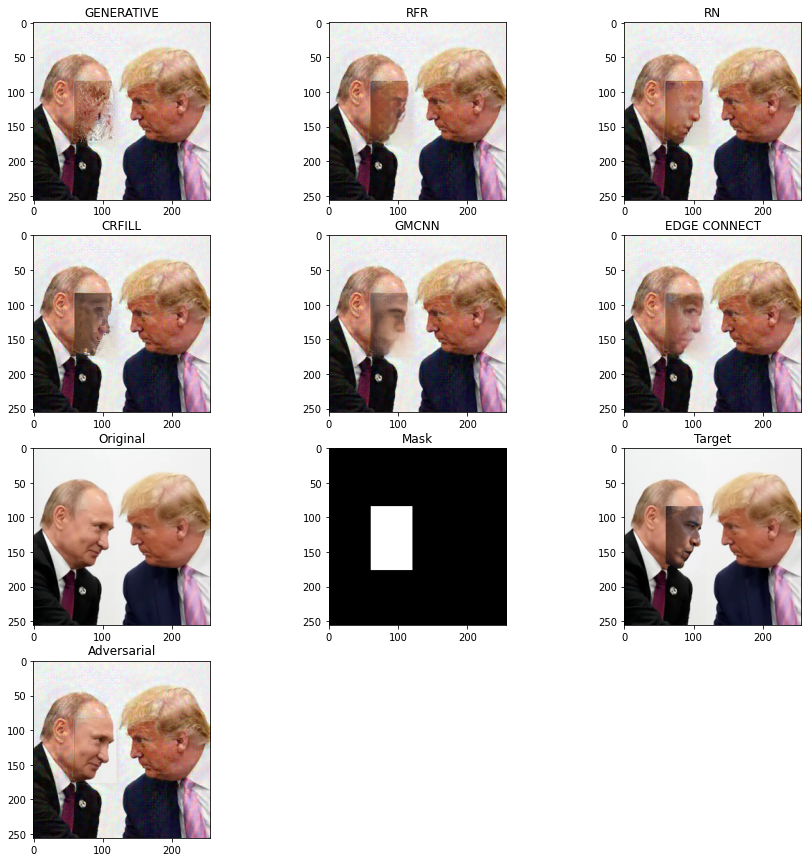

In [10]:
mask =  pil_load(mask_path)
#x = pil_load(image_path)

def gen_mask_to_img_mask(m):
    mask = m.squeeze()
    mask = torch.stack([mask] * 3)
    return mask.permute(1,2,0).squeeze().detach().cpu().numpy()

#mask = torch.zeros([1]+img_shape[:-1])
#mask = transforms.RandomErasing(p=1, scale=(0.05, 0.1), value=1)(mask)
#mask = mask.to(device)

name_map = ["GENERATIVE", "RFR", "RN", "CRFILL", "GMCNN", "EDGE CONNECT", "Original", "Mask", "Target", "Adversarial"]
#for i in TARGET_MODELS:
#    name_map[i] += " (attacked)"
_t = targ #target[0].permute(1,2,0).detach().cpu().numpy()
plot_all(name_map, attack_img, mask, _t, image_path)

In [ ]:
 

mets = ['l1', 'l2','psnr', 'ssim']
whos = ['orig', 'target', 'wouldhave']

keys = []
for w in whos:
  for m in mets:
    key = f"{m}_{w}"
    keys.append(key)

heads = [key[:key.index("_")] for key in keys]
heads = [key.upper() if key in ["ssim", "psnr"] else f"$l_{key[1]}$" for key in heads]


head = "name &" + " & ".join(heads) + "\\\\"

print(head)

for l, n in zip(losses_rn, name_map):

  fin = [f"{n}", ]

  for key in keys:
      val = f"{l[key][0]:.3f}"
      fin.append(val)
  
  print("&" + " & ".join(fin) + "\\\\")


name &$l_1$ & $l_2$ & PSNR & SSIM & $l_1$ & $l_2$ & PSNR & SSIM & $l_1$ & $l_2$ & PSNR & SSIM\\
GENERATIVE & 0.000 & 0.000 & 75.580 & 1.000 & 0.060 & 0.094 & 10.288 & 0.937 & 0.000 & 0.000 & 75.580 & 1.000\\
RFR & 0.002 & 0.000 & 42.006 & 0.997 & 0.029 & 0.022 & 16.655 & 0.949 & 0.001 & 0.000 & 43.907 & 0.997\\
RN & 0.020 & 0.007 & 21.644 & 0.981 & 0.022 & 0.010 & 19.929 & 0.947 & 0.005 & 0.001 & 32.602 & 0.976\\
CRFILL & 0.000 & 0.000 & 89.743 & 1.000 & 0.060 & 0.094 & 10.288 & 0.937 & 0.000 & 0.000 & 89.759 & 1.000\\
GMCNN & 0.004 & 0.001 & 28.771 & 0.988 & 0.061 & 0.092 & 10.378 & 0.934 & 0.000 & 0.000 & 46.617 & 0.999\\
